# Using openCV to detect volvox jamming in a pipe

Note:
after using cv2.imshow to desplay a image, please press any key to close the pop-out window instead of close it manually .

cv2.imshow('detected circles',outputimg)  
cv2.waitKey(0)  
cv2.destroyAllWindows()

In [1]:
from platform import python_version
print(python_version())

3.5.2


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
import os
from skimage import measure

In [3]:
plt.rcParams['figure.figsize'] = [15, 5]

In [4]:
from PIL import Image

In [5]:
def rescaleData(data, mindata=0, maxdata=1):
	return np.interp(data, (data.min(), data.max()), (mindata, maxdata))

In [6]:
def smooth_conv(x,window_len=11,window='flat'):

    if x.ndim != 1:
        raise ValueError ("smooth only accepts 1 dimension arrays.")
    if x.size < window_len:
        raise ValueError ("Input vector needs to be bigger than window size.")
    if window_len<3:
        return x
    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError ("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")
    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')
    y=np.convolve(w/w.sum(),s,mode='valid')
    return y[int((window_len-1)/2):-int((window_len-1)/2+1)]


In [7]:
def rolling_window(a, size):
    shape = a.shape[:-1] + (a.shape[-1] - size + 1, size)
    strides = a.strides + (a. strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

### import image by openCV, get the background

In [8]:

# https://docs.opencv.org/3.4/d1/dc5/tutorial_background_subtraction.html

avifile = '/media/hydroassist/Volvox m2/20191223/R_s_c_pvp025_2.avi'
capture = cv2.VideoCapture(avifile)
backSub = cv2.createBackgroundSubtractorMOG2()

if not capture.isOpened:
    print('Unable to open: ' + file)
    exit(0)
print('width=' ,capture.get(cv2.CAP_PROP_FRAME_WIDTH))
print('height=',capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
totalN = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))
print('length=',totalN)


# while True:
for j in range(1):
    capture = cv2.VideoCapture(avifile)
    for ID in range(60,760):
        capture.set(cv2.CAP_PROP_POS_FRAMES, ID)
        ret, frame = capture.read()
        if frame is None:
            break
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        fgMask = backSub.apply(gray)
        bgimg = backSub.getBackgroundImage()

        
        cv2.rectangle(frame, (10, 2), (100,20), (255,255,255), -1)
        cv2.putText(frame, str(capture.get(cv2.CAP_PROP_POS_FRAMES)), (15, 15), cv2.FONT_HERSHEY_SIMPLEX, 0.5 , (0,0,0))
        cv2.imshow('Frame', frame)
        cv2.imshow('background', bgimg)
#         cv2.imshow('FG Mask', fgMask)


        keyboard = cv2.waitKey(30)
        if keyboard == 'q' or keyboard == 27:
            break
capture.release()  
cv2.destroyAllWindows() 


width= 1563.0
height= 251.0
length= 8030


KeyboardInterrupt: 

In [9]:
capture.release()  
cv2.destroyAllWindows()

In [9]:
bgimgcopy = bgimg.copy()

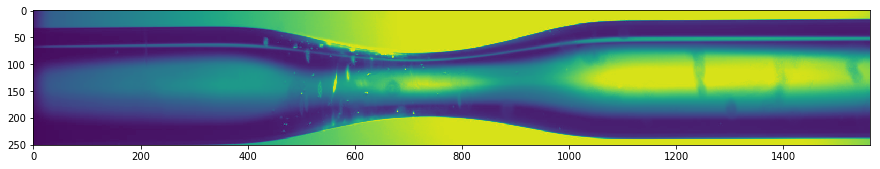

In [12]:
plt.imshow(bgimgcopy)
plt.show()

## calibrate background intensity

## defind the parameter : upbound, lowbound

In [17]:
########## defind the boundary ##########
upbound = 14
lowbound = 249

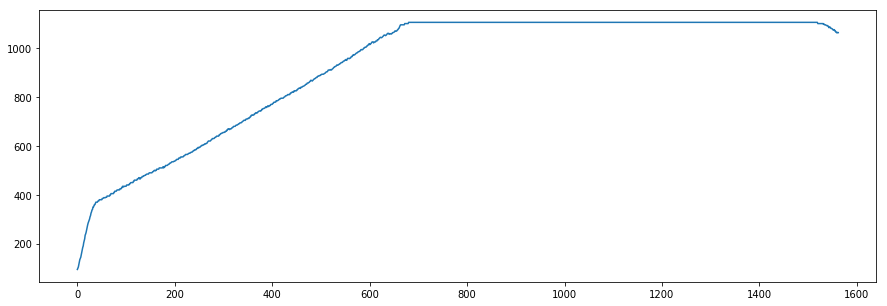

In [18]:
########## calibrate the background intensity ##########
bgbias = np.sum(bgimgcopy[:5],axis=0)
# bgbias = np.sum(bgimgcopy[-5:],axis=0)
plt.plot(bgbias)
plt.show()

In [19]:
# bgbias[:] = 1

## defind tube boundary and remove the outside image

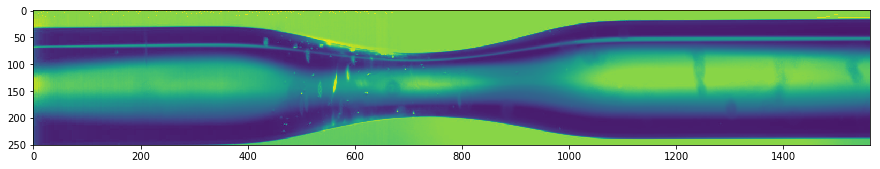

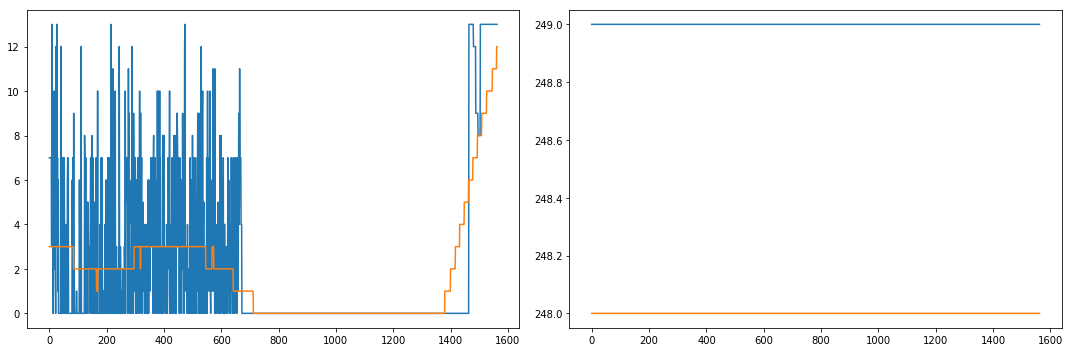

In [21]:
# upbound = 60
# lowbound = 181

bgcopy = (bgimg/bgbias).astype(float)*max(bgbias)
plt.figure(figsize=(15,10))
idx1all = []
idx2all = []
for count,dump in enumerate((bgimg/bgbias).T):
    mididx = int(dump.shape[0]/2)
    diffdump = abs(np.diff(dump.astype(float)))
    idx1 = np.argmax(diffdump[:upbound])
    idx1all.append(idx1)
    idx2 = np.argmax(diffdump[lowbound:])+lowbound
    idx2all.append(idx2)
    bgcopy[idx1,count]=255
    bgcopy[idx2,count]=255
plt.imshow(bgcopy)
plt.show()
    

smoothidx1 = smooth_conv(np.array(idx1all),window_len=200,window='flat')
smoothidx1 = smoothidx1.astype(int)
smoothidx2 = smooth_conv(np.array(idx2all),window_len=200,window='flat')
smoothidx2 = smoothidx2.astype(int)

plt.subplot(1,2,1)
plt.plot(idx1all)
plt.plot(smoothidx1)
plt.subplot(1,2,2)
plt.plot(idx2all)
plt.plot(smoothidx2)
plt.tight_layout()
plt.show()



In [14]:
# smoothidx1[:] = 0
# smoothidx2[:] = bgimg.shape[0]-1

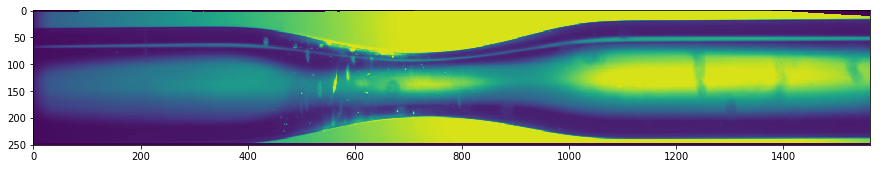

In [22]:
for count in range(len(smoothidx1)):
    bgimg[:smoothidx1[count],count]=0
    bgimg[smoothidx2[count]:,count]=0
plt.figure(figsize=(15,10))
plt.imshow(bgimg)
plt.show()

## detect the volvox by crossing the threshold 

## defind the parameter : cutthreshold

In [23]:
cutthreshold = -10

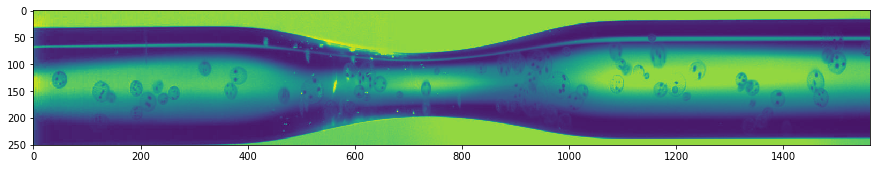

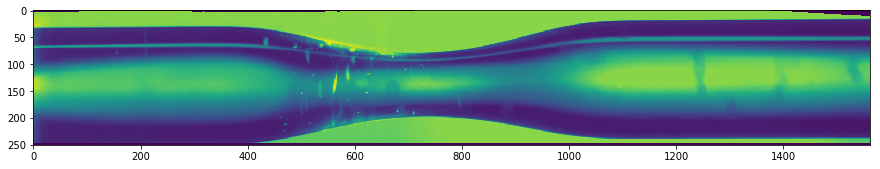

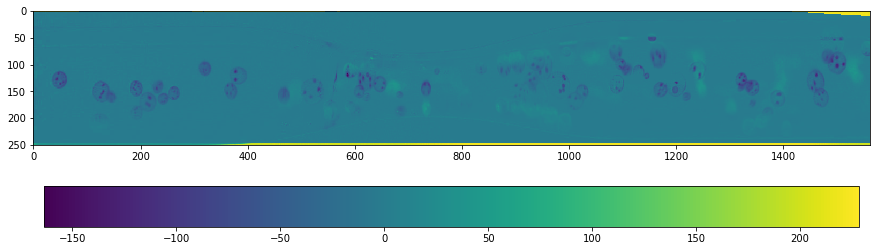

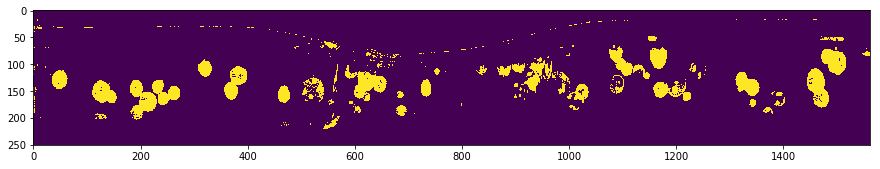

In [24]:
# cutthreshold = -10
FrameID = 3000

cap = cv2.VideoCapture(avifile)
cap.set(cv2.CAP_PROP_POS_FRAMES, FrameID)
ret, frame = cap.read()
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)   
plt.figure(figsize=(15,5))
plt.imshow(gray/bgbias)
plt.show()
plt.figure(figsize=(15,5))
plt.imshow(bgimg/bgbias)
plt.show()
plt.figure(figsize=(15,5))
tempdata = ((gray/bgbias).astype(float)-(bgimg/bgbias).astype(float))*max(bgbias)
if cutthreshold <0:
    tempdatath = (tempdata<cutthreshold)*1
else:
    tempdatath = (tempdata>cutthreshold)*1
im=plt.imshow(tempdata)
plt.colorbar(orientation="horizontal")
plt.show()
plt.figure(figsize=(15,5))
plt.imshow(tempdatath)
plt.show()
cap.release()  

 ## Remove the noise by erode and dilate

In [25]:
FrameID = 3000

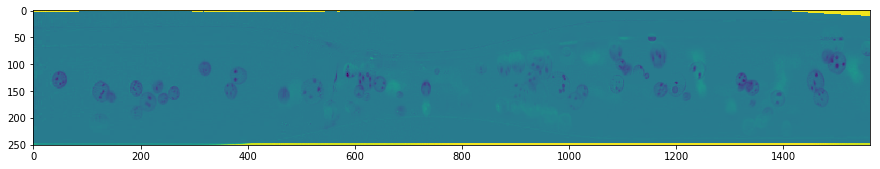

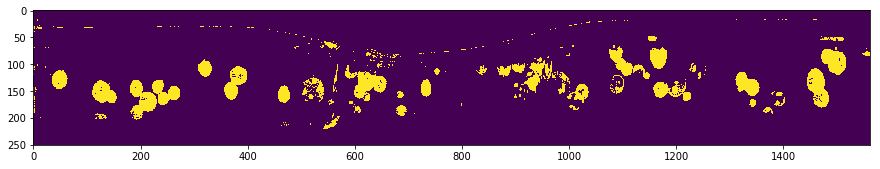

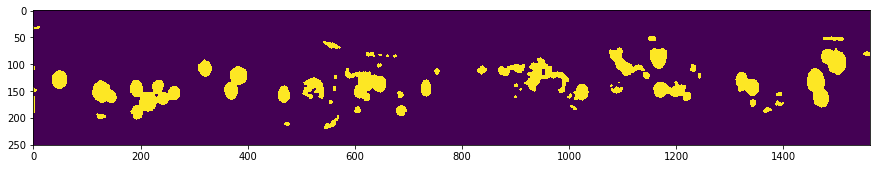

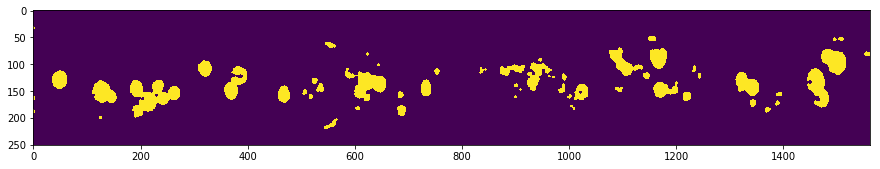

In [26]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))

plt.figure(figsize=(15,5))
cap = cv2.VideoCapture(avifile)
cap.set(cv2.CAP_PROP_POS_FRAMES, FrameID)
ret, frame = cap.read()
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)   
tempdata = ((gray/bgbias).astype(float)-(bgimg/bgbias).astype(float))*max(bgbias)
plt.imshow(tempdata)
plt.show()

plt.figure(figsize=(15,5))
imgsc = rescaleData(tempdata, mindata=0, maxdata=255)
imgsc = imgsc.astype('uint8')
if cutthreshold <0:
    ret,thimg = cv2.threshold(tempdata,cutthreshold,255,cv2.THRESH_BINARY_INV)
else:
    ret,thimg = cv2.threshold(tempdata,cutthreshold,255,cv2.THRESH_BINARY)
plt.imshow(thimg)
plt.show()


closingimg = cv2.morphologyEx(thimg, cv2.MORPH_CLOSE, kernel)
openingimg = cv2.morphologyEx(closingimg, cv2.MORPH_OPEN, kernel)
plt.figure(figsize=(15,5))
plt.imshow(openingimg)
# plt.colorbar()
plt.show()

imgsc = rescaleData(tempdata, mindata=0, maxdata=255)
imgsc = imgsc.astype('uint8')
if cutthreshold <0:
    ret,thimg = cv2.threshold(tempdata,cutthreshold,255,cv2.THRESH_BINARY_INV)
else:
    ret,thimg = cv2.threshold(tempdata,cutthreshold,255,cv2.THRESH_BINARY)
openingimg = cv2.morphologyEx(thimg, cv2.MORPH_OPEN, kernel)
closing = cv2.morphologyEx(openingimg, cv2.MORPH_CLOSE, kernel)
plt.figure(figsize=(15,5))
plt.imshow(closing)
# plt.colorbar()
plt.show()

cap.release()  

### Main program, defind as jamming when the volvox occupied more than  80% (ActThreshold)

In [53]:
# upbound = 60
# lowbound = 181
partL = 25
partA = (lowbound-upbound-1)*partL
partN = int(frame.shape[1]/partL)
# cutthreshold = -20
# kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(6,6))

In [54]:
ActArea = []
JamL = []
leftidxall = []
rightidxall = []
ActThreshold = 0.8



capture = cv2.VideoCapture(avifile)
if not capture.isOpened:
    print('Unable to open: ' + args.input)
    exit(0)

loopcount = 0
# while True:
for ID in range(0,totalN):
#     print(loopcount)
    capture.set(cv2.CAP_PROP_POS_FRAMES, ID)
    ret, frame = capture.read()
    if frame is None:
        break
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)   
    ########## remove background ##########
    img = ((gray/bgbias).astype(float)-(bgimg/bgbias).astype(float))*max(bgbias)
    
    ########## remove noise by eroid and dilate ##########
    if cutthreshold <0:
        ret,thimg = cv2.threshold(img,cutthreshold,255,cv2.THRESH_BINARY_INV)
    else:
        ret,thimg = cv2.threshold(img,cutthreshold,255,cv2.THRESH_BINARY)
#     openingimg = cv2.morphologyEx(thimg, cv2.MORPH_OPEN, kernel)
#     closingimg = cv2.morphologyEx(openingimg, cv2.MORPH_CLOSE, kernel)
    closingimg = cv2.morphologyEx(thimg, cv2.MORPH_CLOSE, kernel)
    openingimg = cv2.morphologyEx(closingimg, cv2.MORPH_OPEN, kernel)
    EDimg = openingimg # Dilation and Erosion
    
    ########## calculate the occupied density ##########
    ActNow = []
    for i in range(partN):
        ActNow.append(np.sum(EDimg[upbound:lowbound, i*partL:(i+1)*partL])/partA/255.0)
    ActArea.append(ActNow)    
    
    ########## calculate the jamming area ##########
    JamA=(np.array(ActNow)>ActThreshold)*1
    
    dump = np.nonzero(np.all(rolling_window(JamA, 3) == [1,0,1], axis=1))[0]
    if len(dump) != 0:   
        fillidx = dump+1
        JamA[fillidx]=1
        
    if np.sum(JamA)>0.5:
        bwlabels=measure.label(JamA,connectivity=1) 
        hist, bin_edges = np.histogram(bwlabels,bins=bwlabels.max()+1)
        jamidx = np.argmax(hist[1:])+1
        percoidx = np.nonzero((bwlabels==jamidx)*1)[0]
        leftidx = np.min(percoidx)
        rightidx = np.max(percoidx)
        JamL.append(rightidx-leftidx)
        leftidxall.append(leftidx)
        rightidxall.append(rightidx)
    else:
        leftidx = 0
        rightidx = 0
        JamL.append(0)
        leftidxall.append(0)
        rightidxall.append(0)

    loopcount += 1
    
    ########## label the information on the frame ##########
    centYidx = int(EDimg.shape[0]/2)
    centYidx = 10
    if rightidx != 0:
        cv2.line(frame,(leftidx*partL,centYidx),((rightidx+1)*partL,centYidx),(0, 0, 255), 5)
    cv2.rectangle(frame, (10, 2), (100,20), (255,255,255), -1)
    cv2.putText(frame, str(capture.get(cv2.CAP_PROP_POS_FRAMES)), (15, 15), cv2.FONT_HERSHEY_SIMPLEX, 0.5 , (0,0,0))    
    
    for i in range(partN):
        if ActNow[i]>ActThreshold:
            overlay = frame.copy()
            cv2.rectangle(overlay, (i*partL,upbound), ((i+1)*partL,lowbound), (0,0,255), -1)
            alpha = 0.4
            frame = cv2.addWeighted(overlay, alpha, frame, 1 - alpha, 0)
        cv2.rectangle(frame, (i*partL,upbound), ((i+1)*partL,lowbound), (0,255,0), 1)
        if i%2 == 0 :
            cv2.putText(frame, str(ActNow[i])[:5], (i*partL,upbound), cv2.FONT_HERSHEY_SIMPLEX, 0.5 , (0,255,0))
        else :
            cv2.putText(frame, str(ActNow[i])[:5], (i*partL,upbound-15), cv2.FONT_HERSHEY_SIMPLEX, 0.5 , (0,255,0))
    cv2.imshow('Frame', frame)
    
    ########## display the EDimage ##########
    if rightidx != 0:
        EDimg[centYidx-2:centYidx+2,leftidx*partL:(rightidx+1)*partL]=128
    cv2.imshow('EDimg', EDimg)
    
    keyboard = cv2.waitKey(30)
    if keyboard == 'q' or keyboard == 27:
        break

capture.release()                    
cv2.destroyAllWindows()



In [ ]:
# capture.release()                    
# cv2.destroyAllWindows()

## the jamming length

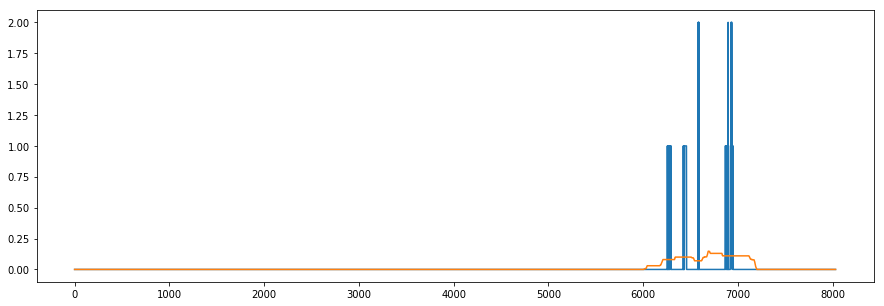

In [55]:
if np.nonzero(JamL)[0].shape[0]>5:
    plt.figure(figsize=(15,5))
    smoothJamL = smooth_conv(np.array(JamL),window_len=500,window='flat')
    plt.plot(JamL)
    plt.plot(smoothJamL)
    plt.show()

## fitting the jamming length

In [ ]:
## defind the parameter : t1,t2

In [ ]:
from scipy import stats
t1 = 8000
t2 = len(smoothJamL)
fps = 25
scalebar = 1/150 # 1mm = 108 pixel
td = t2-t1
gapsize = min(smoothidx2-smoothidx1)*scalebar
gapsize = (lowbound-upbound)*scalebar
gapsize = 150 *scalebar
tubesize = 1.12
tubesize = 215 * scalebar
distance = partL*scalebar
fitdata = smoothJamL[t1:t2]
timedata = np.linspace(t1,t2,num=td)
slope, intercept, r_value, p_value, std_err = stats.linregress(timedata,fitdata)

print('jamming speed = ',slope,' 25pixel/frame')
print('jamming speed = ',slope*partL*fps*scalebar,' mm/s')
print('gapsize = ',gapsize,'mm')
print('gapratio = ',gapsize/tubesize,'mm')

plt.plot(JamL)
plt.plot(smoothJamL)
plt.plot(timedata, intercept + slope*(timedata), 'r', label='fitted line')
plt.show()

## save data

In [ ]:
plt.figure(figsize=(15,5))

plt.plot(JamL, label='jamming length')
plt.plot(smoothJamL,label='smooth')
plt.plot(timedata, intercept + slope*(timedata), 'r', label='fitted line')
plt.text(0, np.max(JamL)-np.max(JamL)/4, 'slope='+str(slope*partL*fps*scalebar)[:6], fontsize=24)
# plt.text(0, np.max(JamL)-np.max(JamL)/2,'speed is too slow' , fontsize=24)
plt.title(avifile.split('/')[-1][:-4], fontsize=24)
plt.legend()
locs, labels = plt.xticks()
plt.xticks(locs,locs/fps, fontsize=20)
plt.xlabel('time (s)', fontsize=24)
locs, labels = plt.yticks()
plt.yticks(locs,np.around(locs*distance, decimals=2) , fontsize=20)
plt.ylabel('jamming length (mm)', fontsize=24)
plt.savefig(avifile[:-4] + '_jamming.png', bbox_inches='tight')
plt.show()

outfile = avifile[:-4]+'.npz'
np.savez(outfile, ActArea=ActArea, leftidxall=leftidxall, rightidxall=rightidxall)

In [ ]:
# ActArea = np.reshape(ActArea,[-1,partN]).T

In [ ]:
int((np.argmin(smoothidx2-smoothidx1))/partL)

In [ ]:
fig, axs = plt.subplots(partN,1, figsize=(15, partN))
fig.subplots_adjust(hspace=0.001)

for count,i in enumerate(np.array(ActArea).T):
    axs[count].plot(i)
    axs[count].set_ylim([0,1.1])
    if count < partN-1:
        axs[count].set_xticklabels(())
        axs[count].title.set_visible(False)

axs[int((np.argmin(smoothidx2-smoothidx1))/partL)].set_facecolor('lightgreen')
plt.show()

## save the data

In [ ]:
# cv2.destroyAllWindows()